In [160]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import sklearn
from random import random
from sklearn.model_selection import cross_validate
import matplotlib
from waveform_methods import binning
import pandas as pd

from scipy.stats import norm
import pickle
from statistics import mode
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import scale

In [161]:
file = uproot.open('/home/andy/12360.root')
file2 = uproot.open('/home/andy/12362.root')

In [162]:
print(file['Stoch_Reco'].keys())

[b'Run', b'Event', b'SubEvent', b'SubEventStream', b'SubEventStream_String', b'exists', b'eloss_1000', b'eloss_1500', b'eloss_1600', b'eloss_1700', b'eloss_1800', b'eloss_1900', b'eloss_2000', b'eloss_2100', b'eloss_2200', b'eloss_2300', b'eloss_2400', b'eloss_3000', b'a_estim', b'a_estim_err', b'e0_estim', b'e0_estim_err', b'stoch_energy', b'rel_stoch_energy', b'total_stoch_energy', b'total_rel_stoch_energy', b'highest_stoch_energy', b'highest_rel_stoch_energy', b'chi2', b'chi2_red', b'stoch_depth', b'n_he_stoch', b'fit_status', b'fit_status_String']


In [163]:
Eloss_keys = file['Stoch_Reco'].keys()[6:18]
for i in range(len(Eloss_keys)):
    if i == 0:
        Eloss1 = file['Stoch_Reco'][Eloss_keys[i]].array()
    else:
        Eloss1 += file['Stoch_Reco'][Eloss_keys[i]].array()
Eloss1 = Eloss1/len(Eloss_keys)

Eloss_keys = file2['Stoch_Reco'].keys()[6:18]
for i in range(len(Eloss_keys)):
    if i == 0:
        Eloss2 = file2['Stoch_Reco'][Eloss_keys[i]].array()
    else:
        Eloss2 += file2['Stoch_Reco'][Eloss_keys[i]].array()
Eloss2 = Eloss2/len(Eloss_keys)

Eloss = np.append(Eloss1,Eloss2)

In [164]:
cut = []
for i in file['IT73AnalysisInIceQualityCuts'].keys()[6:11]:
    cut.append(file['IT73AnalysisInIceQualityCuts'][i].array())
cut2 = list(zip(cut))
for i in range(len(cut2)):
    if i == 0:
        final_cut = cut2[i][0]
    else:
        final_cut = [j and k for j,k in zip(final_cut,cut2[i][0])]
        
cut = []
for i in file2['IT73AnalysisInIceQualityCuts'].keys()[6:11]:
    cut.append(file2['IT73AnalysisInIceQualityCuts'][i].array())
cut2 = list(zip(cut))
for i in range(len(cut2)):
    if i == 0:
        final_cut2 = cut2[i][0]
    else:
        final_cut2 = [j and k for j,k in zip(final_cut,cut2[i][0])]
        
in_ice_cuts = np.append(final_cut,final_cut2)

In [165]:
Xmax1 = file['MCPrimaryInfo']['ghMaxDepth'].array()
valueDepth = file['MCPrimaryInfo']['longNumCharged'].array()
Depth1 = file['MCPrimaryInfo']['longDepth'].array()
chi2_1 = file['CurvatureOnlyParams']['chi2_time'].array()
red1 = file['MCPrimaryInfo']['ghRedChiSqr'].array()
mass1 = [1 for i in range(len(red1))]
        
Xmax2 = file2['MCPrimaryInfo']['ghMaxDepth'].array()
valueDepth = file2['MCPrimaryInfo']['longNumCharged'].array()
Depth2 = file2['MCPrimaryInfo']['longDepth'].array()
chi2_2 = file2['CurvatureOnlyParams']['chi2_time'].array()
red2 = file2['MCPrimaryInfo']['ghRedChiSqr'].array()
mass2 = [4 for i in range(len(red2))]


In [166]:
S125_1 = file['LaputopParams']['s125'].array()
S125_2 = file2['LaputopParams']['s125'].array()
A1 = file['CurvatureOnlyParams']['A'].array()
A2 = file2['CurvatureOnlyParams']['A'].array()
D1 = file['CurvatureOnlyParams']['D'].array()
D2 = file2['CurvatureOnlyParams']['D'].array()
N1 = file['CurvatureOnlyParams']['N'].array()
N2 = file2['CurvatureOnlyParams']['N'].array()
beta1 = file['LaputopParams']['beta'].array()
beta2 = file2['LaputopParams']['beta'].array()
zenith1 = file['Laputop']['zenith'].array()
zenith2 = file2['Laputop']['zenith'].array()
energy1 = file['MCPrimary']['energy'].array()
energy2 = file2['MCPrimary']['energy'].array()
stoch1_1 = file['Stoch_Reco']['n_he_stoch'].array()
stoch1_2 = file2['Stoch_Reco']['n_he_stoch'].array()
stoch2_1 = file['Stoch_Reco2']['n_he_stoch'].array()
stoch2_2 = file2['Stoch_Reco2']['n_he_stoch'].array()

slc_charge1 = file['LaputopSLCPE']['charge'].array()
slc_charge2 = file2['LaputopSLCPE']['charge'].array()

slc_charge1 = [np.sum(i[np.isnan(i)==False]) for i in slc_charge1]
slc_charge2 = [np.sum(i[np.isnan(i)==False]) for i in slc_charge2]

hlc_charge1 = file['LaputopHLCPE']['charge'].array()
hlc_charge2 = file2['LaputopHLCPE']['charge'].array()

hlc_charge1 = [np.sum(i[np.isnan(i) ==False]) for i in hlc_charge1]
hlc_charge2 = [np.sum(i[np.isnan(i)==False]) for i in hlc_charge2]

Qtot1 = [i+j for i,j in zip(slc_charge1,hlc_charge1)]
Qtot2 = [i+j for i,j in zip(slc_charge2,hlc_charge2)]

In [167]:
A = np.append(A1,A2)
D = np.append(D1,D2)
N = np.append(N1,N2)
S125 = np.log10(np.append(S125_1,S125_2))
beta = np.log10(np.append(beta1,beta2))
chi2 = np.append(chi2_1,chi2_2)
red = np.append(red1,red2)
zenith = np.cos(np.append(zenith1,zenith2))
Xmax = np.append(Xmax1,Xmax2)
red = np.append(red1,red2)
mass = np.append(mass1,mass2)
slc_charge = np.append(slc_charge1,slc_charge2)
hlc_charge = np.append(hlc_charge1,hlc_charge2)
qtot = np.append(Qtot1,Qtot2)
stoch1 = np.append(stoch1_1,stoch1_2)
stoch2 = np.append(stoch2_1,stoch2_2)
for i in range(len(stoch1)):
    if not in_ice_cuts[i]:
        stoch1[i] = 0
        stoch2[i] = 0

energy_loss = Eloss
for i in range(len(energy_loss)):
    if ((energy_loss[i] != 0 and in_ice_cuts[i]) and np.isfinite(energy_loss[i])) and not np.isnan(energy_loss[i]):
        energy_loss[i] = np.log10(abs(energy_loss[i]))
    else:
        energy_loss[i] = 0
        
energy = np.log10(np.append(energy1,energy2))

In [168]:
values = [mass,
            energy_loss,
            stoch1,
            stoch2,
            A,
            D,
            N,
            S125,
            beta,
            zenith,
            chi2,
            slc_charge,
            hlc_charge,
            qtot
            ]

print(np.corrcoef(values))

[[ 1.00000000e+00 -1.67488960e-01 -1.59570024e-01 -1.19173749e-01
  -1.91653200e-01 -1.32195338e-01  1.25447376e-01  4.29808393e-02
  -2.00833332e-01  1.33948905e-02  5.60756736e-04  2.68353149e-01
  -1.26407490e-02 -1.08003071e-02]
 [-1.67488960e-01  1.00000000e+00  8.08854556e-01  3.82294608e-01
   6.20143587e-02 -5.45574992e-02 -4.71564816e-02  1.91778746e-01
   1.59400512e-01  3.30219081e-01 -2.20658129e-02 -6.91919950e-02
   1.49829065e-01  1.49196148e-01]
 [-1.59570024e-01  8.08854556e-01  1.00000000e+00  5.23775355e-01
   8.03260903e-02 -1.17366307e-02 -4.60883112e-02  1.29606149e-01
   1.45734553e-01  3.12321477e-01 -1.32530912e-02 -8.71389675e-02
   1.18129195e-01  1.17408360e-01]
 [-1.19173749e-01  3.82294608e-01  5.23775355e-01  1.00000000e+00
   9.62204274e-02  5.95681240e-02 -4.57410568e-02 -1.92431528e-02
   9.24728093e-02  2.00266772e-01  3.91724063e-03 -1.02598803e-01
   1.45791996e-03  7.57915232e-04]
 [-1.91653200e-01  6.20143587e-02  8.03260903e-02  9.62204274e-02
  

In [169]:
import random
#model coinc:slc_charge,A,N,beta,energy_loss,stoch1,zenith
#model not coinc:slc_charge,beta,A,zenith
input_variable2_old = np.array(list(zip(slc_charge,A,energy_loss,beta,stoch1,S125)))[in_ice_cuts]
output_new_old = mass[in_ice_cuts]
energy_value = energy[in_ice_cuts]

validation = []
output = []

for i in range(len(input_variable2_old)):
    if random.random() < 0.1:
        validation.append(i)
    else:
        output.append(i)
        
validation_x = input_variable2_old[validation]
validation_y = output_new_old[validation]
input_variable = np.array(input_variable2_old)[output]
output_new = np.array(output_new_old)[output]
energy_value = energy_value[output]

In [170]:
from sklearn.preprocessing import minmax_scale
import keras
from keras import initializers,regularizers
from keras.layers import Dense, Dropout, Flatten, Input, Concatenate, LeakyReLU
from keras.models import Model, load_model
import keras.backend as K
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_math_ops as math_ops
from sklearn.model_selection import train_test_split

In [171]:
train_features,test_features,train_labels,test_labels = train_test_split(input_variable,output_new,test_size=0.2,random_state=42)

In [172]:
best_model = keras.callbacks.ModelCheckpoint('Mass_model_best.h5',
                                             monitor='val_loss',
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='auto')

In [175]:
input_layer = Input(shape=(6,))

model1 = Dense(7)(input_layer)

model1 = LeakyReLU()(model1)

model1 = Dropout(rate=0.1)(model1)

model2 = Dense(4)(model1)

model2 = LeakyReLU()(model2)

predictions = Dense(1,activation='linear')(model2)

model = Model(inputs=input_layer,outputs=predictions)

opt = keras.optimizers.RMSprop(decay=1e-5)
#opt= keras.optimizers.Adam(decay=1e-5,lr=3e-4)                                                               

model.compile(optimizer=opt , loss = 'mse')

print(model.summary())

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 6)                 0         
_________________________________________________________________
dense_88 (Dense)             (None, 7)                 49        
_________________________________________________________________
leaky_re_lu_59 (LeakyReLU)   (None, 7)                 0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_89 (Dense)             (None, 4)                 32        
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 4)                 0         
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 5  

In [176]:
history = model.fit(train_features,train_labels,
                    batch_size=15,
                    epochs=10,
                    validation_data = (test_features,test_labels),
                    callbacks=[best_model],
                   class_weight = {1:0.125,4:0.875})

model.save('Mass_model.h5')

Train on 18778 samples, validate on 4695 samples
Epoch 1/10
18778/18778 [==============================] - 1s 62us/step - loss: 0.4933 - val_loss: 1.3819
Epoch 2/10
18778/18778 [==============================] - 1s 57us/step - loss: 0.3726 - val_loss: 1.4311
Epoch 3/10
18778/18778 [==============================] - 1s 56us/step - loss: 0.3318 - val_loss: 1.1495
Epoch 4/10
18778/18778 [==============================] - 1s 55us/step - loss: 0.3139 - val_loss: 1.0931
Epoch 5/10
18778/18778 [==============================] - 1s 55us/step - loss: 0.3042 - val_loss: 1.0826
Epoch 6/10
18778/18778 [==============================] - 1s 57us/step - loss: 0.2986 - val_loss: 1.2387
Epoch 7/10
18778/18778 [==============================] - 1s 57us/step - loss: 0.2995 - val_loss: 0.9234
Epoch 8/10
18778/18778 [==============================] - 1s 57us/step - loss: 0.2959 - val_loss: 1.0534
Epoch 9/10
18778/18778 [==============================] - 1s 57us/step - loss: 0.2914 - val_loss: 1.0776
Epoch 

In [177]:
new_model = load_model('Mass_model_best.h5')
predict = new_model.predict(validation_x)

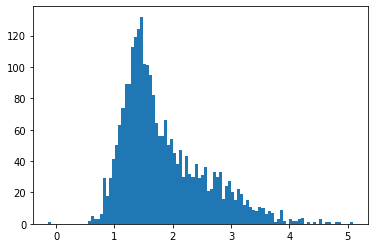

274
1954


In [178]:
plt.hist(predict,bins=100)
plt.show()
count = 0
for i in predict[validation_y==4]>2.5:
    if i:
        count+=1
print(count)

count = 0
for i in predict[validation_y==1]<2.5:
    if i:
        count+=1
print(count)

In [179]:
count = 0
for i in validation_y==1:
    if i:
        count+=1
print(count)

count = 0
for i in validation_y==4:
    if i:
        count+=1
print(count)

2153
380


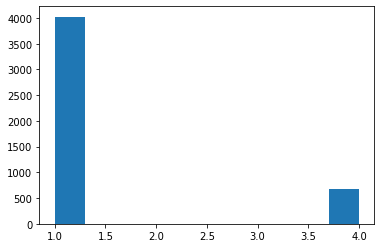

In [180]:
plt.hist(test_labels)
plt.show()